# Imports

In [ ]:
import os

import glob

from tqdm.notebook import tqdm

from pathlib import Path

from PIL import Image

from skimage.color import rgb2lab, lab2rgb

import tarfile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.utils import make_grid
from torchvision.utils import save_image

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

# Device

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cpu')

# Download Dataset

In [ ]:
dataset_url = 'https://s3.amazonaws.com/fast-ai-coco/coco_sample.tgz'
download_url(dataset_url, '.')

  0%|          | 0/3245877008 [00:00<?, ?it/s]

In [ ]:
with tarfile.open('/content/coco_sample.tgz', 'r:gz') as tar:
    tar.extractall(path = './data')

In [ ]:
dir_path = r'/content/data/coco_sample/train_sample'
count = 0

for path in os.listdir(dir_path):
    if os.path.isfile(os.path.join(dir_path, path)):
        count += 1

print('File count:', count)

File count: 21837


In [ ]:
# We will randomly select 10,000 of these images to form our training and validation sets
paths = glob.glob(dir_path + '/*.jpg')

np.random.seed(123)
paths_subset = np.random.choice(paths, 10000, replace = False)
rand_idxs = np.random.permutation(10000)
train_idxs = rand_idxs[:8000]
val_idxs = rand_idxs[8000:]
train_paths = paths_subset[train_idxs]
val_paths = paths_subset[val_idxs]

print(len(train_paths), len(val_paths))

8000 2000


# Prepare Dataset

In [ ]:
image_size = 240
batch_size = 32

In [ ]:
transform_train = transforms.Compose([
                      transforms.Resize((240,240)),
                      transforms.RandomHorizontalFlip()])

transform_val = transforms.Resize((240,240))

In [ ]:
class ColorizationDataset(Dataset):
    def __init__(self, paths, transform):
          super().__init__()
          self.paths = paths
          self.transform = transform

    def __len__(self):
          return len(self.paths)

    def __getitem__(self, index):
        img = Image.open(self.paths[index]).convert('RGB')
        img = self.transform(img)
        
        # Convert from RGB to L*a*b
        img = np.array(img)
        img_lab = rgb2lab(img).astype('float32')
        img_lab = transforms.ToTensor()(img_lab)

        # Values in L channel lie between [0, 100] and in the a, b channels between [-110, 110]
        # Convert to values between -1 to 1
        L = img_lab[[0], ...] / 50 - 1
        ab = img_lab[[1, 2], ...] / 110

        return L, ab

# Load Data

In [ ]:
def get_loader(paths, transform, batch_size = batch_size, shuffle = False, num_workers = 4, pin_memory = True):
    dataset = ColorizationDataset(paths, transform = transform)
    loader = DataLoader(dataset = dataset, batch_size = batch_size, num_workers = num_workers, pin_memory = pin_memory)

    return loader, dataset

In [ ]:
train_dl, train_ds = get_loader(train_paths, transform_train)
val_dl, val_ds = get_loader(val_paths, transform_val)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Visualize Examples

In [ ]:
def lab_to_rgb(L, ab):
    # Denormalizing the channels
    L = (L + 1) * 50
    ab = ab * 110

    # Concatenate back the channels
    Labs = torch.cat([L, ab], dim = 1)
    imgs = []

    # Convert each image to RGB individually
    for Lab in torch.tensor_split(Labs, batch_size, dim=0):
        Lab = torch.squeeze(Lab)
        Lab = Lab.permute(1, 2, 0)
        img = lab2rgb(Lab)
        img = transforms.ToTensor()(img)
        imgs.append(img)
    
    return imgs

def show_images(L, ab, nmax=64):
    L1 = L.detach()[:nmax]
    ab1 = ab.detach()[:nmax]
    off = lab_to_rgb(L1, ab1)
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(lab_to_rgb(L1, ab1), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for L, ab in dl:
        show_images(L, ab, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


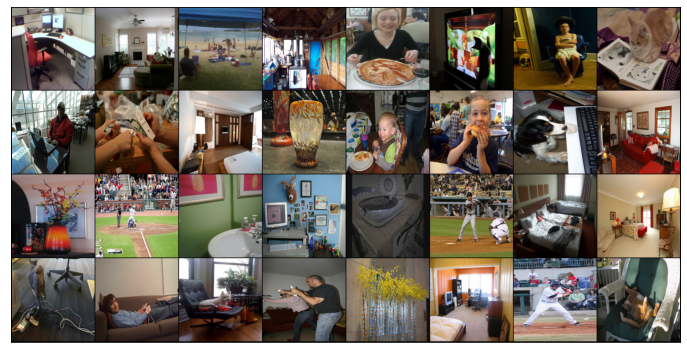

In [ ]:
show_batch(train_dl)

# Discriminator Model

In [ ]:
class PatchDiscriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.network = nn.Sequential(
            # in: 3 x 256 x 256

            nn.Conv2d(in_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 64 x 128 x 128

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 128 x 64 x 64

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 256 x 32 x 32

            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            # out: 512 x 30 x 30

            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)
            # out: 1 x 30 x 30
        )

    def forward(self, x):
        return self.network(x)

# Generator Model

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.network(x)

class UNetGenerator(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, features=[32, 64, 128, 256]):
        super().__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of the U-Net
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of the U-Net
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

# Stitching The Complete Model

In [ ]:
class GANLoss(nn.Module):
    def __init__(self, real_label=1.0, fake_label=0.0):
        super().__init__()
        self.register_buffer('real_label', torch.tensor(real_label))
        self.register_buffer('fake_label', torch.tensor(fake_label))
        self.loss = nn.BCEWithLogitsLoss()

    def get_labels(self, preds, target_is_real):
        if target_is_real:
            labels = self.real_label
        else:
            labels = self.fake_label
        return labels.expand_as(preds)

    def __call__(self, preds, target_is_real):
        labels = self.get_labels(preds, target_is_real)
        loss = self.loss(preds, labels)
        return loss

In [ ]:
def init_weights(network):

    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and 'Conv' in classname:
            nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        
        elif 'BatchNorm2d' in classname:
            nn.init.normal_(m.weight.data, 1., 0.02)
            nn.init.constant_(m.bias.data, 0.)
    
    network.apply(init_func)
    print('Model weights initialized from a Gaussian distribution')
    return network

def init_model(model, device):
    model = model.to(device)
    model = init_weights(model)
    return model

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok = True)

In [ ]:
class MainModel(nn.Module):
    def __init__(self, lr=0.0002, lambda_L1 = 100.):
        super().__init__()
        self.lambda_L1 = lambda_L1

        self.net_G = init_model(UNetGenerator(), device)
        self.net_D = init_model(PatchDiscriminator(), device)

        self.GANcriterion = GANLoss().to(device)
        self.L1criterion = nn.L1Loss()

        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr, betas=(0.5, 0.999))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr, betas=(0.5, 0.999))

    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad

    def setup_input(self, L, ab):
        self.L = L.to(device)
        self.ab = ab.to(device)

    def forward(self):
        self.fake_color = self.net_G(self.L)

    def optimize(self, mode='Train'):
        self.forward()
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)

        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5

        if mode == 'Train':
            self.net_D.train()
            self.set_requires_grad(self.net_D, True)
            self.opt_D.zero_grad()
            self.loss_D.backward()
            self.opt_D.step()

        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1

        if mode == 'Train':
            self.net_G.train()
            self.set_requires_grad(self.net_G, False)
            self.opt_G.zero_grad()
            self.loss_G.backward()
            self.opt_G.step()

        return self.loss_D, self.loss_G

    def save_samples(self, index):
        fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
        save_image(lab_to_rgb(self.L, self.fake_color), os.path.join(sample_dir, fake_fname), nrow=8)
        print('Saving', fake_fname)

    def save_models(self):
        torch.save(self.net_G.state_dict(), 'G.pth')
        torch.save(self.net_D.state_dict(), 'D.pth')

    def load_models(self, G_path, D_path):
        self.net_G.load_state_dict(torch.load(G_path))
        self.net_D.load_state_dict(torch.load(D_path))

# Training The Model

In [ ]:
def train_model(model, train_dl, epochs=10):
    loss_G_train = []
    loss_D_train = []

    for epoch in range(epochs):
        loss_G_val = 0
        loss_D_val = 0
        for L, ab in tqdm(train_dl):
            model.setup_input(L, ab)
            loss_D, loss_G = model.optimize()
            loss_D_train.append(loss_D)
            loss_G_train.append(loss_G)
            model.optimize(loss_D, loss_G)

        for data in tqdm(val_dl):
            model.setup_input(data)
            loss_D, loss_G = model.optimize('Val')
            loss_G_val += loss_G
            loss_D_val += loss_D

        print('Epoch [{}/{}], val_loss_g: {:4f}, val_loss_d: {:4f}'.format(epoch+1, epochs, loss_G/125, loss_D/(8000/batch_size)))

    return loss_D_train, loss_G_train

In [ ]:
model = MainModel()
history = train_model(model, train_dl)

Model weights initialized from a Gaussian distribution
Model weights initialized from a Gaussian distribution


  0%|          | 0/250 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


RuntimeError: ignored

#Saving The Model

In [ ]:
model.save_models()

#Results

In [ ]:
pretrained_model = MainModel()
pretrained_model.load_models('G.pth', 'D.pth')